In [1]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator
from scipy.stats import gaussian_kde

from src.networks import AmortizedMixture, AmortizedPosteriorMixture
from src.models.MixtureNormal import modelFixedContext, configurator, constrain_parameters
from amortizer import amortizer
from cmdstanpy import CmdStanModel
from logging import getLogger

stan_logger = getLogger("cmdstanpy")
stan_logger.disabled = True

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 196, 5)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Shape of simulation non-batchable context: (2,)
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from checkpoints/amortizer/history_100.pkl.
INFO:root:Networks loaded from checkpoints/amortizer/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [2]:
colors = {
    "Prior": '#999999',
    "BayesFlow": '#005b96',
    "Stan": '#7C0000',
    "Truth": '#ced932',
    "Components": ['#E69F00', '#009E73', '#CC79A7']
}

In [3]:
stan_model = CmdStanModel(stan_file="../../stan/mixture-normal.stan")

In [4]:
true_params = np.array([[0.3, 0.5, 0.2, -1.8, -0.5, 1.2]])
model = modelFixedContext(n_obs=200, n_rep=3)

df = model.simulator(true_params)
df['prior_draws'] = true_params
df['sim_non_batchable_context'] = np.array([200, 3])

# reorder data points based on their means
ind =df['sim_data'][:,:,:-1]
ind = np.argsort(np.mean(ind, axis=-1)[0])
df['sim_data'] = df['sim_data'][:,ind]

df = configurator(df)

observables = df['posterior_inputs']['summary_conditions'][0,...,0]
means = np.array(np.mean(observables, axis=-1))
latents = np.array(df['mixture_inputs']['latents'][0,0])

stan_df = {
    "n_obs": 200,
    "n_cls": 3,
    "n_rep": 3,
    "y": observables,
    "mu_prior": [-2.0, 0.0, 2.0],
    "mixture_prior": [2, 2, 2]
}

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 200, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Shape of simulation non-batchable context: (2,)
INFO:root:No optional simulation batchable context provided.


In [5]:
bf_unconstrained_posterior, bf_class_membership = amortizer.sample(df, n_samples=4000)
bf_unconstrained_posterior = bf_unconstrained_posterior[0]
bf_class_membership = bf_class_membership[0]
bf_posterior = constrain_parameters(bf_unconstrained_posterior)

In [6]:
stan_fit = stan_model.sample(stan_df, show_progress=False)
print(stan_fit.diagnose())

Processing csv files: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmp3i9fng15/mixture-normalooms4dxb/mixture-normal-20250116134809_1.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmp3i9fng15/mixture-normalooms4dxb/mixture-normal-20250116134809_2.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmp3i9fng15/mixture-normalooms4dxb/mixture-normal-20250116134809_3.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmp3i9fng15/mixture-normalooms4dxb/mixture-normal-20250116134809_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [7]:
stan_posterior = stan_fit.draws_pd(vars = ["p", "mu"])
stan_posterior = np.array(stan_posterior)

In [8]:
# if desired, test how the mixture network performs with the parameter samples from Stan
# df['mixture_inputs']['parameters'] = np.expand_dims(unconstrain_parameters(stan_posterior), axis=0).astype(np.float32)
# bf_class_membership = amortizer.amortized_mixture.sample(df['mixture_inputs'])
# bf_class_membership = bf_class_membership[0]

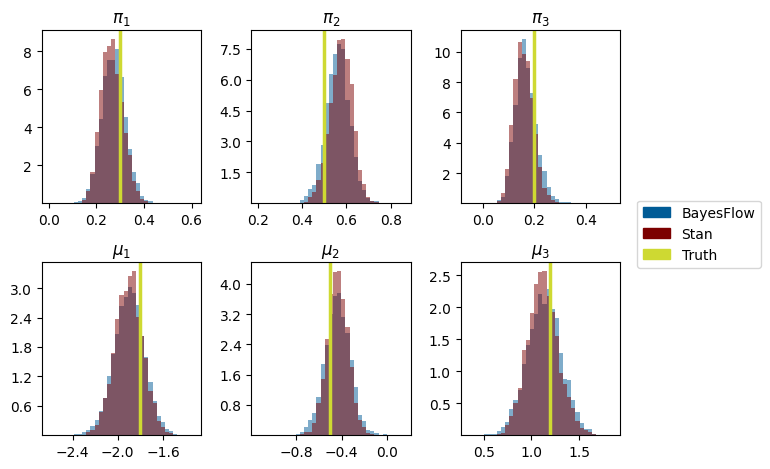

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=3)
plt.rcParams['figure.figsize'] = [8, 6]

axs = axs.flatten()

bins = [
    np.linspace(np.min(bf_posterior[:,i])-0.1, np.max(bf_posterior[:,i])+0.1, 36) for i in range(6)
]
for i, par in enumerate(model.param_names['constrained']):
    axs[i].hist(bf_posterior[:,i], bins=bins[i], alpha = 0.5, density=True, color=colors['BayesFlow'])
    axs[i].hist(stan_posterior[:,i], bins=bins[i], alpha = 0.5, density=True, color=colors['Stan'])
    axs[i].axvline(true_params[0,i], linewidth=2.5, c=colors['Truth'])
    axs[i].xaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
    axs[i].yaxis.set_major_locator(MaxNLocator(nbins=6, prune='both'))
    axs[i].set_title(par)


fig.subplots_adjust(right=0.8)
keys=['BayesFlow', 'Stan', 'Truth']
handles=[patches.Patch(color=colors[k]) for k in keys]
fig.legend(handles, keys, bbox_to_anchor=(1.1, 0.5), loc='center')
fig.tight_layout()

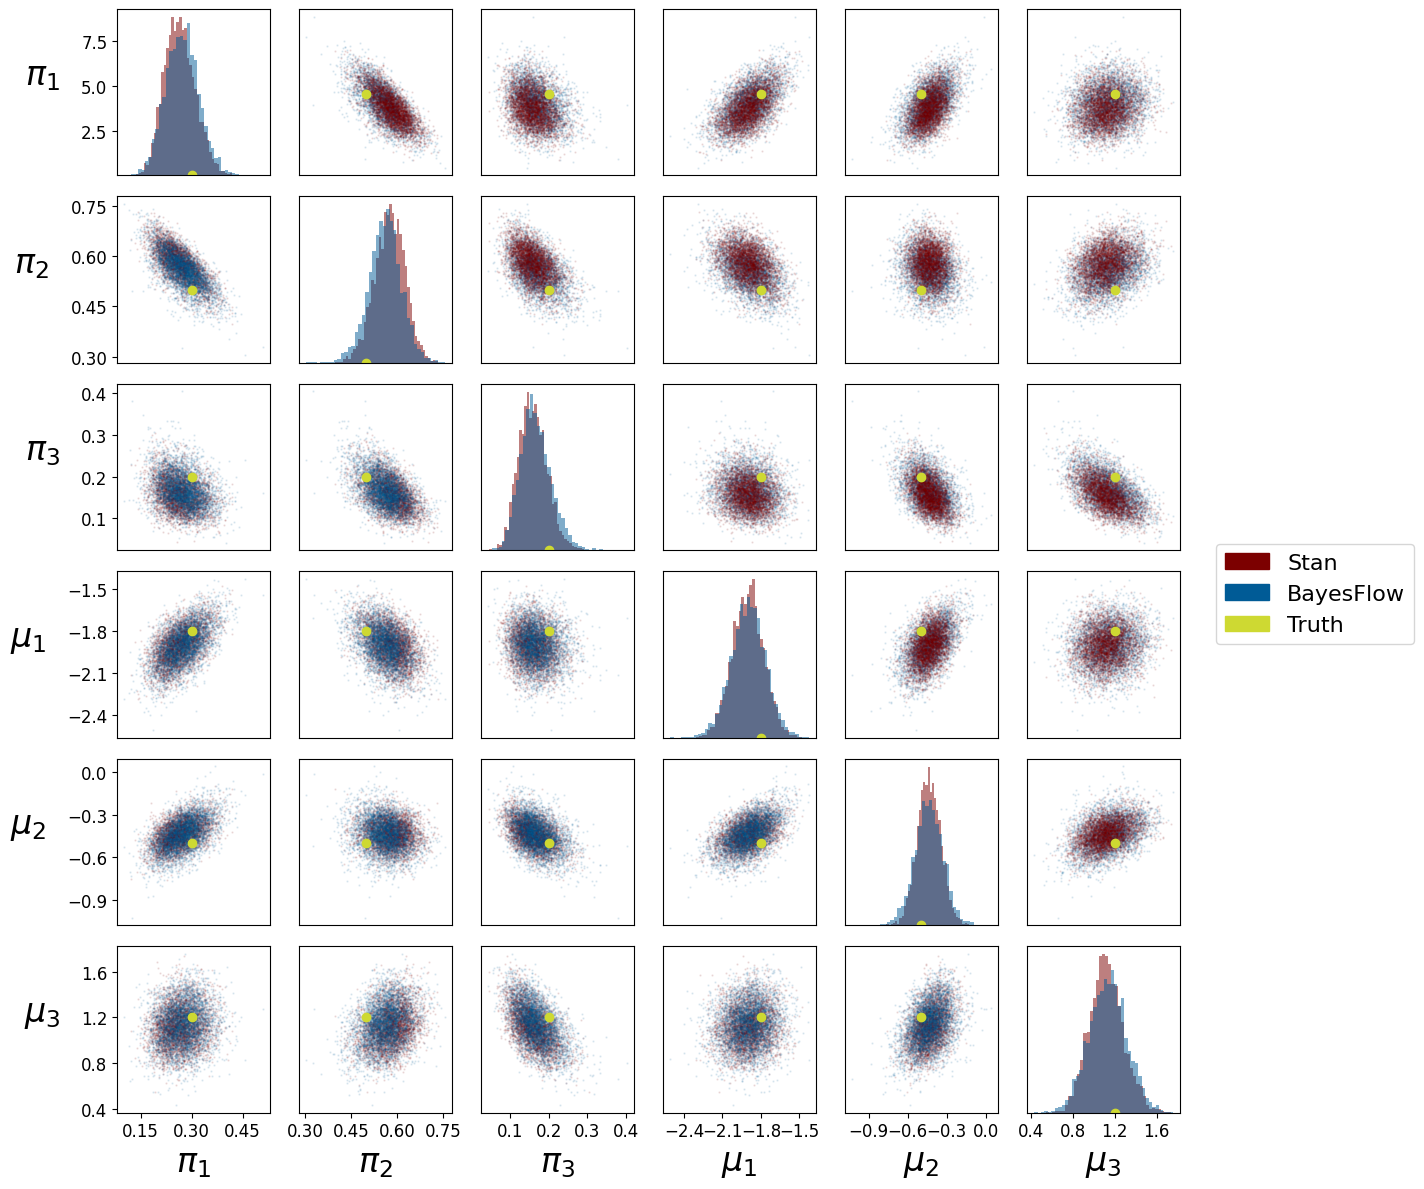

In [10]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, axs = plt.subplots(nrows=len(model.param_names['constrained']), ncols=len(model.param_names['constrained']))

bins = [
    np.linspace(np.min(bf_posterior[:,i])-0.1, np.max(bf_posterior[:,i])+0.1, 36) for i in range(6)
]

for xi, x_par in enumerate(model.param_names['constrained']):
    axs[-1,xi].set_xlabel(x_par, fontsize=24)
    for yi, y_par in enumerate(model.param_names['constrained']):
        if xi != 0 and yi != len(model.param_names['constrained']) - 1:
            axs[yi,xi].set(xticklabels=[], yticklabels=[])
            axs[yi,xi].tick_params(bottom=False, left=False)
        elif xi == 0 and yi != len(model.param_names['constrained']) - 1:
            axs[yi, xi].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
            axs[yi,xi].set(xticklabels=[])
            axs[yi,xi].tick_params(bottom=False, labelsize=12)
        elif xi != 0 and yi == len(model.param_names['constrained']) - 1:
            axs[yi, xi].xaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
            axs[yi,xi].set(yticklabels=[])
            axs[yi,xi].tick_params(left=False, labelsize=12)
        else:
            axs[yi, xi].xaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
            axs[yi, xi].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
            axs[yi,xi].tick_params(labelsize=12)

        if xi == yi:
            axs[yi,0].set_ylabel(y_par, fontsize=24, rotation=0, labelpad=28)
            axs[yi,xi].hist(stan_posterior[:,xi], bins=40,alpha = 0.5, density=True, color=colors['Stan'])
            axs[yi,xi].hist(bf_posterior[:,xi], bins=40,alpha = 0.5, density=True, color=colors['BayesFlow'])
            axs[yi,xi].scatter(true_params[0,xi], 0, color=colors['Truth'])
        elif xi > yi:
            axs[yi, xi].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
            axs[yi,xi].scatter(bf_posterior[:,xi], bf_posterior[:,yi], s=0.5, alpha=0.1, color=colors['BayesFlow'])
            axs[yi,xi].scatter(stan_posterior[:,xi], stan_posterior[:,yi], s=0.5, alpha=0.1, color=colors['Stan'])
            axs[yi,xi].scatter(true_params[0,xi], true_params[0,yi], color=colors['Truth'])
        else:
            axs[yi, xi].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
            axs[yi,xi].scatter(bf_posterior[:,xi], bf_posterior[:,yi], s=0.5, alpha=0.1, color=colors['BayesFlow'], zorder=2)
            axs[yi,xi].scatter(stan_posterior[:,xi], stan_posterior[:,yi], s=0.5, alpha=0.1, color=colors['Stan'],zorder=1)
            axs[yi,xi].scatter(true_params[0,xi], true_params[0,yi], color=colors['Truth'], zorder=3)

fig.subplots_adjust(right=0.8)
keys=['Stan', 'BayesFlow', 'Truth']
handles=[patches.Patch(color=colors[k]) for k in keys]
fig.legend(handles, keys, bbox_to_anchor=(1.1, 0.5), loc='center', fontsize=16)
fig.tight_layout()

## Classification

In [11]:
stan_class_membership = stan_fit.stan_variables()["class_membership"]

losses = {
    "stan": amortizer.amortized_mixture.loss(np.tile(np.expand_dims(latents, 0), (4000, 1, 1)), stan_class_membership),
    "bf": amortizer.amortized_mixture.loss(np.tile(np.expand_dims(latents, 0), (4000, 1, 1)), bf_class_membership)
}
losses

{'stan': <tf.Tensor: shape=(), dtype=float64, numpy=0.7123179286360106>,
 'bf': <tf.Tensor: shape=(), dtype=float32, numpy=0.7116482>}

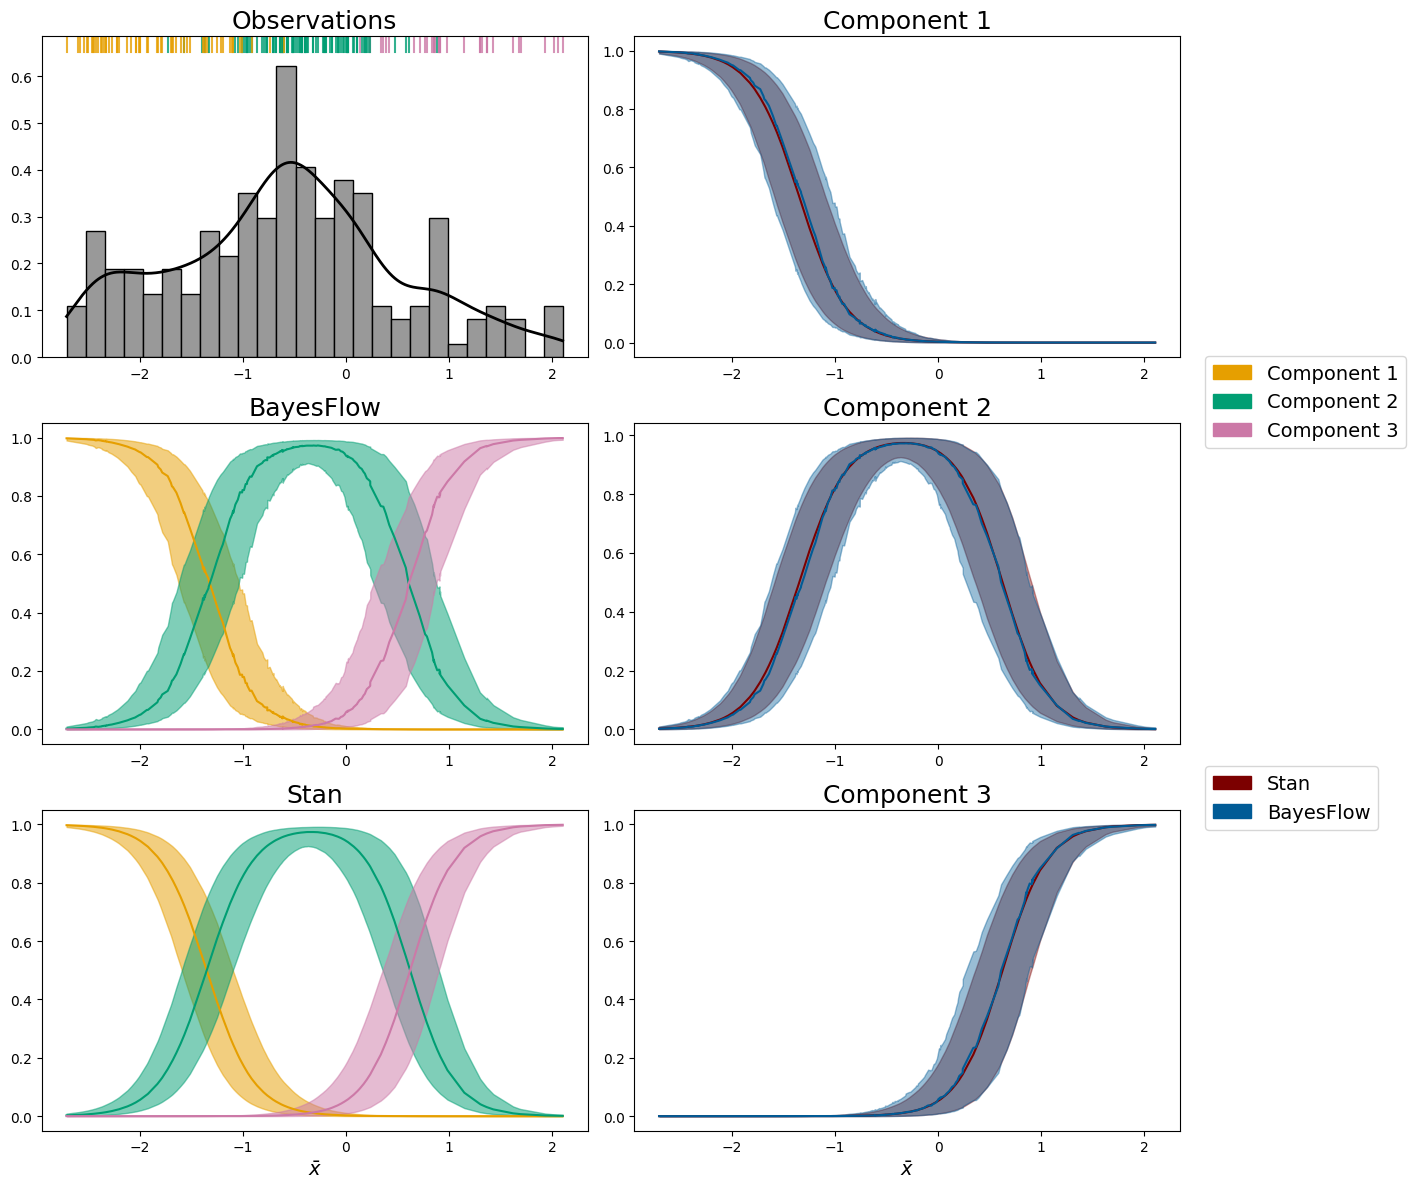

In [12]:
quantiles = [0.025, 0.975]

fig, axs = plt.subplots(3, 2)
plt.rcParams['figure.figsize'] = [10, 8]

axs[0,0].set_title("Observations", fontsize=18)
axs[1,0].set_title("BayesFlow", fontsize=18)
axs[2,0].set_title("Stan", fontsize=18)

# Observations
for i in range(means.shape[0]):
    axs[0,0].axvline(means[i], ymin=0.95, ymax=1, alpha=0.8, color=colors['Components'][np.argmax(latents[i])])
axs[0,0].hist(means, bins=26, density=True, color=colors['Prior'], edgecolor='black')
kde = gaussian_kde(means, bw_method=0.25)
x_range = np.linspace(np.min(means), np.max(means), 1000)
axs[0,0].plot(x_range, kde(x_range), color='black', linestyle='-', linewidth=2)
y_min, y_max = axs[0,0].get_ylim()
axs[0,0].set_ylim(y_min, y_max * 1.05)


for cls in range(3):
    axs[1,0].plot(means, np.median(bf_class_membership[...,cls], axis=0), color=colors['Components'][cls])
    axs[1,0].fill_between(
        means,
        np.quantile(bf_class_membership[...,cls], q=quantiles[0], axis=0),
        np.quantile(bf_class_membership[...,cls], q=quantiles[1], axis=0),
        alpha=0.5,
        color=colors['Components'][cls]
    )

    axs[2,0].plot(means, np.median(stan_class_membership[...,cls], axis=0), color=colors['Components'][cls], label="P(z={})".format(cls+1))
    axs[2,0].fill_between(
        means,
        np.quantile(stan_class_membership[...,cls], q=quantiles[0], axis=0),
        np.quantile(stan_class_membership[...,cls], q=quantiles[1], axis=0),
        alpha=0.5,
        color=colors['Components'][cls]
    )


for cls in range(3):
    axs[cls,1].set_title("Component {}".format(cls+1), fontsize=18)
    axs[cls,1].plot(means, np.median(stan_class_membership[...,cls], axis=0), color=colors['Stan'])
    axs[cls,1].fill_between(
        means,
        np.quantile(stan_class_membership[...,cls], q=quantiles[0], axis=0),
        np.quantile(stan_class_membership[...,cls], q=quantiles[1], axis=0),
        alpha=0.4,
        color=colors['Stan']
    )
    
    axs[cls,1].plot(means, np.median(bf_class_membership[...,cls], axis=0), color=colors['BayesFlow'])
    axs[cls,1].fill_between(
        means,
        np.quantile(bf_class_membership[...,cls], q=quantiles[0], axis=0),
        np.quantile(bf_class_membership[...,cls], q=quantiles[1], axis=0),
        alpha=0.4,
        color=colors['BayesFlow']
    )
    
axs[-1,0].set_xlabel(r"$\bar{x}$", fontsize=14)
axs[-1,1].set_xlabel(r"$\bar{x}$", fontsize=14)

fig.subplots_adjust(right=0.8)
keys=["Component {}".format(cls+1) for cls in range(3)]
handles=[patches.Patch(color=col) for col in colors["Components"]]
fig.legend(handles, keys, bbox_to_anchor=(1.0, 0.66), loc='center left', fontsize=14)

keys=['Stan' ,'BayesFlow']
handles=[patches.Patch(color=colors[k]) for k in keys]
fig.legend(handles, keys, bbox_to_anchor=(1.0, 0.33), loc='center left', fontsize=14)


fig.tight_layout()
